# Excercise: Diabetes models

### Pedro Bueso-Inchausti García

## 1. Objective

Implement different classifiers for our diabetes dataset


## 2. Pre-requisites

We import all the library and functions needed.

In [30]:
import os
import numpy
import pandas
import seaborn
import findspark
findspark.init()
from os import getcwd
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import NaiveBayes, MultilayerPerceptronClassifier, LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, GBTClassifier

We initialise the Spark Context and the SQL Context.

In [2]:
sc = SparkContext(master = 'local[4]')
sqlc = SQLContext(sc)

We define the formats available.

In [3]:
formats = ["cca","knn","hd","em"]

We load the training datasets.

In [9]:
for format in formats:
    locals()["train_data_"+format] = sqlc.read.format('csv').option('header','true')\
    .option('inferSchema','true').load("diabetes_"+format+"_train.csv")

We load the test dataset.

In [10]:
test_data = sqlc.read.format('csv').option('header','true').option('inferSchema','true').load("diabetes_na_test.csv")

## 3. Modelling

We prepare data for modelization, this requires creating an indexedLabel and an indexedFeatures columns

In [11]:
feature_columns = list(test_data.toPandas().columns)[0:-1]
label_column = test_data.toPandas().columns[-1]

In [12]:
assem = VectorAssembler(inputCols=feature_columns, outputCol="Features")
for format in formats:
    locals()["train_data_"+format] = assem.transform(locals()["train_data_"+format])
test_data = assem.transform(test_data)

In [17]:
train_data_cca.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Features
0,1,143,74,22,61,26.2,0.256,21,0,"[1.0, 143.0, 74.0, 22.0, 61.0, 26.2, 0.256, 21.0]"
1,1,109,38,18,120,23.1,0.407,26,0,"[1.0, 109.0, 38.0, 18.0, 120.0, 23.1, 0.407, 2..."
2,5,123,74,40,77,34.1,0.269,28,0,"[5.0, 123.0, 74.0, 40.0, 77.0, 34.1, 0.269, 28.0]"
3,11,136,84,35,130,28.3,0.260,42,1,"[11.0, 136.0, 84.0, 35.0, 130.0, 28.3, 0.26, 4..."
4,2,123,48,32,165,42.1,0.520,26,0,"[2.0, 123.0, 48.0, 32.0, 165.0, 42.1, 0.52, 26.0]"


We define an evaluator which will be used to evaluate each algorithm

In [18]:
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="Prediction", metricName="accuracy")

### Naive Bayes

In [19]:
nb = NaiveBayes(labelCol="Outcome", featuresCol="Features", predictionCol="Prediction")
pg_nb = ParamGridBuilder().addGrid(nb.smoothing, [0.25,0.5,0.75]).build()
cv_nb = CrossValidator(estimator=nb, estimatorParamMaps=pg_nb, evaluator=evaluator, numFolds=3)

for format in formats:
    locals()["model_nb_"+format] = cv_nb.fit(locals()["train_data_"+format])
    locals()["train_nb_"+format] = locals()["model_nb_"+format].transform(locals()["train_data_"+format])
    print("Accuracy in the train_data_"+format)
    print(evaluator.evaluate(locals()["train_nb_"+format]))

Accuracy in the train_data_cca
0.6418092909535452
Accuracy in the train_data_knn
0.6802807913209955
Accuracy in the train_data_hd
0.6496490108487556
Accuracy in the train_data_em
0.6994256541161455


### Logistic regression

In [20]:
lr = LogisticRegression(labelCol="Outcome", featuresCol="Features", predictionCol="Prediction")
pg_lr = ParamGridBuilder().addGrid(lr.regParam, [0.1,0.05,0.01]).addGrid(lr.elasticNetParam, [0.1,0.05,0.01]).build()
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=pg_lr, evaluator=evaluator, numFolds=3)

for format in formats:
    locals()["model_lr_"+format] = cv_lr.fit(locals()["train_data_"+format])
    locals()["train_lr_"+format] = locals()["model_lr_"+format].transform(locals()["train_data_"+format])
    print("Accuracy in the train_data_"+format)
    print(evaluator.evaluate(locals()["train_lr_"+format]))

Accuracy in the train_data_cca
0.7921760391198044
Accuracy in the train_data_knn
0.7708998085513721
Accuracy in the train_data_hd
0.7798340778557754
Accuracy in the train_data_em
0.7779195915762603


### Multilayer perceptron classifier

In [21]:
mlp = MultilayerPerceptronClassifier(labelCol="Outcome", featuresCol="Features", predictionCol="Prediction")
pg_mlp = ParamGridBuilder().addGrid(mlp.layers, [[8,5,5,2],[8,10,10,2],[8,15,15,2]]).build()
cv_mlp = CrossValidator(estimator=mlp, estimatorParamMaps=pg_mlp, evaluator=evaluator, numFolds=3)

for format in formats:
    locals()["model_mlp_"+format] = cv_mlp.fit(locals()["train_data_"+format])
    locals()["train_mlp_"+format] = locals()["model_mlp_"+format].transform(locals()["train_data_"+format])
    print("Accuracy in the train_data_"+format)
    print(evaluator.evaluate(locals()["train_mlp_"+format]))

Accuracy in the train_data_cca
0.7322738386308069
Accuracy in the train_data_knn
0.7249521378430122
Accuracy in the train_data_hd
0.6783663050414805
Accuracy in the train_data_em
0.7645181876196554


### Decision Tree

In [22]:
dt = DecisionTreeClassifier(labelCol="Outcome", featuresCol="Features", predictionCol="Prediction")
pg_dt = ParamGridBuilder().addGrid(dt.maxDepth, [4,6,8,10]).build()
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=pg_dt, evaluator=evaluator, numFolds=3)

for format in formats:
    locals()["model_dt_"+format] = cv_dt.fit(locals()["train_data_"+format])
    locals()["train_dt_"+format] = locals()["model_dt_"+format].transform(locals()["train_data_"+format])
    print("Accuracy in the train_data_"+format)
    print(evaluator.evaluate(locals()["train_dt_"+format]))

Accuracy in the train_data_cca
0.9877750611246944
Accuracy in the train_data_knn
0.9725590299936184
Accuracy in the train_data_hd
0.97702616464582
Accuracy in the train_data_em
0.99234205488194


### Random forest classifier

In [23]:
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="Features", predictionCol="Prediction")
pg_rf = ParamGridBuilder().addGrid(rf.numTrees,[20,40]).addGrid(rf.maxDepth,[5,10]).build()
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=pg_rf, evaluator=evaluator, numFolds=3)

for format in formats:
    locals()["model_rf_"+format] = cv_rf.fit(locals()["train_data_"+format])
    locals()["train_rf_"+format] = locals()["model_rf_"+format].transform(locals()["train_data_"+format])
    print("Accuracy in the train_data_"+format)
    print(evaluator.evaluate(locals()["train_rf_"+format]))

Accuracy in the train_data_cca
0.9987775061124694
Accuracy in the train_data_knn
0.9974473516273133
Accuracy in the train_data_hd
0.9865985960433951
Accuracy in the train_data_em
0.9929802169751116


### Gradient boosted tree classifier

In [24]:
gbt = GBTClassifier(labelCol="Outcome", featuresCol="Features", predictionCol="Prediction")
pg_gbt = ParamGridBuilder().addGrid(gbt.maxIter,[20,40]).addGrid(gbt.maxDepth,[5,10]).build()
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=pg_gbt, evaluator=evaluator, numFolds=3)

for format in formats:
    locals()["model_gbt_"+format] = cv_gbt.fit(locals()["train_data_"+format])
    locals()["train_gbt_"+format] = locals()["model_gbt_"+format].transform(locals()["train_data_"+format])
    print("Accuracy in the train_data_"+format)
    print(evaluator.evaluate(locals()["train_gbt_"+format]))

Accuracy in the train_data_cca
1.0
Accuracy in the train_data_knn
0.994256541161455
Accuracy in the train_data_hd
0.9629865985960434
Accuracy in the train_data_em
0.9680918953414167


## 4. Results

We see which are the results in our test data

In [31]:
methods = ["Naive Bayes","Multilayer Perceptron","Logistic Regression","Decision Tree","Random Forest","Gradient Boosted Tree"]

for format in formats:
    
    locals()["test_nb_"+format] = locals()["model_nb_"+format].transform(test_data)
    locals()["test_mlp_"+format] = locals()["model_mlp_"+format].transform(test_data)
    locals()["test_lr_"+format] = locals()["model_lr_"+format].transform(test_data)
    locals()["test_dt_"+format] = locals()["model_dt_"+format].transform(test_data)
    locals()["test_rf_"+format] = locals()["model_rf_"+format].transform(test_data)
    locals()["test_gbt_"+format] = locals()["model_gbt_"+format].transform(test_data)

    results = [evaluator.evaluate(locals()["test_nb_"+format]),
               evaluator.evaluate(locals()["test_mlp_"+format]),
               evaluator.evaluate(locals()["test_lr_"+format]),
               evaluator.evaluate(locals()["test_dt_"+format]),
               evaluator.evaluate(locals()["test_rf_"+format]),
               evaluator.evaluate(locals()["test_gbt_"+format])]
    
    methods_results = {'Methods':methods,'Results':results}
    locals()["results_"+format] = pandas.DataFrame(methods_results)                                                    
    locals()["file_path"+format] = os.path.join(getcwd(),'Models',"results_"+format+".csv")
    locals()["results_"+format].to_csv(locals()["file_path"+format],index=False)

We compare the predictions, row by row, for each algorithm and whether they agree or not with the real outcome. We save the csv files that are produced.

In [34]:
columns = ["Naive Bayes","Multilayer Perceptron","Logistic Regression",
"Decision Tree","Random Forest","Gradient Boosted Tree", "Outcome"]

for format in formats:
    
    locals()["comparisons_"+format] = pandas.concat([locals()["test_nb_"+format].toPandas()['Prediction'],
    locals()["test_mlp_"+format].toPandas()['Prediction'],locals()["test_lr_"+format].toPandas()['Prediction'],
    locals()["test_dt_"+format].toPandas()['Prediction'],locals()["test_rf_"+format].toPandas()['Prediction'],
    locals()["test_gbt_"+format].toPandas()['Prediction'],test_data.toPandas()['Outcome']],axis=1)
    
    locals()["comparisons_"+format].columns = columns                                              
    locals()["comparisons_"+format] = locals()["comparisons_"+format].applymap(numpy.int64)
    
    locals()["file_path"+format] = os.path.join(getcwd(),'Models',"comparisons_"+format+".csv")
    locals()["comparisons_"+format].to_csv(locals()["file_path"+format],index=False)

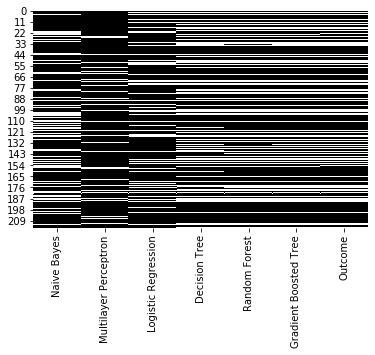

In [35]:
seaborn.heatmap(comparisons_cca, cbar=False, cmap='gray')

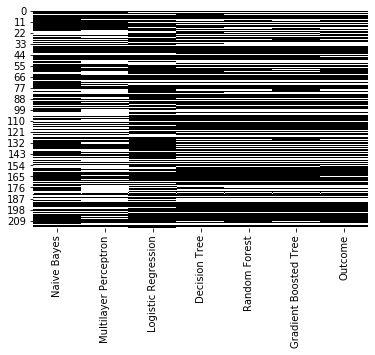

In [36]:
seaborn.heatmap(comparisons_knn, cbar=False, cmap='gray')

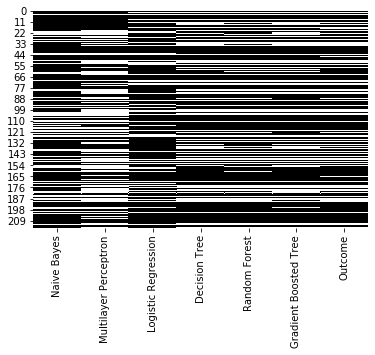

In [37]:
seaborn.heatmap(comparisons_hd, cbar=False, cmap='gray')

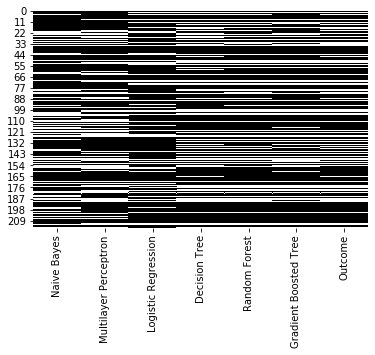

In [38]:
seaborn.heatmap(comparisons_em, cbar=False, cmap='gray')

We visualize the trees

In [66]:
import json

def parse(lines):
    block = []
    while lines :

        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name':bl, 'children':parse(lines)})

            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name':be, 'children':parse(lines)})
        elif not lines[0].startswith(('If','Else')):
            block2 = lines.pop(0)
            block.append({'name':block2})
        else:
            break
    return block
    
def tree_json(tree):
    data = []
    for line in tree.splitlines() : 
        if line.strip():
            line = line.strip()
            data.append(line)
        else : break
        if not line : break
    res = []
    res.append({'name':'Root', 'children':parse(data[1:])})
    return res[0]

tree_cca = model_dt_cca.bestModel.toDebugString
tree_json(tree_cca)

{'name': 'Root',
 'children': [{'name': 'feature 1 <= 126.5',
   'children': [{'name': 'feature 6 <= 0.6385000000000001',
     'children': [{'name': 'feature 5 <= 46.4',
       'children': [{'name': 'feature 0 <= 12.5',
         'children': [{'name': 'feature 2 <= 81.0',
           'children': [{'name': 'feature 0 <= 0.5',
             'children': [{'name': 'feature 7 <= 27.5',
               'children': [{'name': 'feature 4 <= 66.5',
                 'children': [{'name': 'feature 3 <= 31.5',
                   'children': [{'name': 'Predict: 0.0'}]},
                  {'name': 'feature 3 > 31.5',
                   'children': [{'name': 'Predict: 1.0'}]}]},
                {'name': 'feature 4 > 66.5',
                 'children': [{'name': 'Predict: 0.0'}]}]},
              {'name': 'feature 7 > 27.5',
               'children': [{'name': 'Predict: 1.0'}]}]},
            {'name': 'feature 0 > 0.5',
             'children': [{'name': 'feature 3 <= 39.5',
               'children': [{'